# Predicting yeilds.

There are 10^10 stars in the LMC and 5x10^9 stars in the SMC. The DEC detector has 62 chips, 4k x 4k. 16Mpixels. 10^5 stars per chip.

In [1]:
Nstars = 10**5 * 62
Nstars

6200000

Around 0.2% of stars have hot Jupiters.

In [2]:
NhotJs = .002 * Nstars
NhotJs

12400.0

But not all of these will transit.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import batman

In [4]:
df = pd.read_csv("KOIs.csv", skiprows=53)
for i in df.keys():
    print(i)

loc_rowid
kepid
kepoi_name
kepler_name
koi_disposition
koi_pdisposition
koi_score
koi_fpflag_nt
koi_fpflag_ss
koi_fpflag_co
koi_fpflag_ec
koi_period
koi_period_err1
koi_period_err2
koi_time0bk
koi_time0bk_err1
koi_time0bk_err2
koi_impact
koi_impact_err1
koi_impact_err2
koi_duration
koi_duration_err1
koi_duration_err2
koi_depth
koi_depth_err1
koi_depth_err2
koi_prad
koi_prad_err1
koi_prad_err2
koi_teq
koi_teq_err1
koi_teq_err2
koi_insol
koi_insol_err1
koi_insol_err2
koi_model_snr
koi_tce_plnt_num
koi_tce_delivname
koi_steff
koi_steff_err1
koi_steff_err2
koi_slogg
koi_slogg_err1
koi_slogg_err2
koi_srad
koi_srad_err1
koi_srad_err2
ra
dec
koi_kepmag


Select G stars and remove false positives.

In [5]:
m = df.koi_steff.values < 6000
m &= 5200 < df.koi_steff.values
m &= df.koi_pdisposition.values == "CANDIDATE"
m &= df.koi_disposition.values == "CONFIRMED"

m2 = df.koi_pdisposition.values == "CANDIDATE"
m2 &= df.koi_disposition.values == "CONFIRMED"

df_G = df.iloc[m]

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


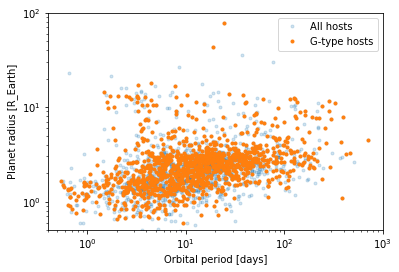

In [6]:
plt.loglog(df.koi_period.values[m2], df.koi_prad.values[m2], ".", alpha=.2, label="All hosts")
plt.loglog(df_G.koi_period, df_G.koi_prad, ".", label="G-type hosts")
plt.xlabel("Orbital period [days]")
plt.ylabel("Planet radius [R_Earth]")
plt.ylim(.5, 100)
plt.xlim(.4, 1000)
plt.legend()

Text(0,0.5,'Depth')

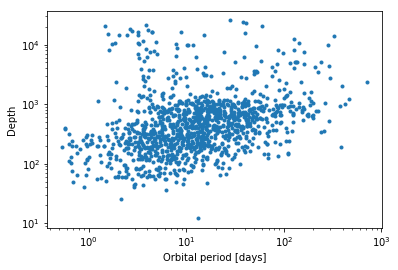

In [7]:
plt.loglog(df_G.koi_period, df_G.koi_depth, ".")
plt.xlabel("Orbital period [days]")
plt.ylabel("Depth")

114
9564


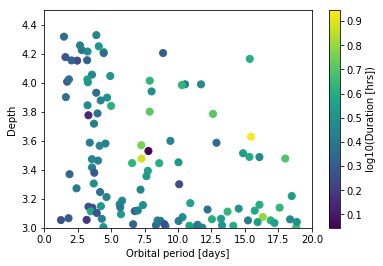

In [8]:
m = df_G.koi_period.values < 20
m &= np.log10(df_G.koi_depth) < 4.5
m &= 3 < np.log10(df_G.koi_depth)
plt.scatter(df_G.koi_period.values[m], np.log10(df_G.koi_depth.values[m]), 
            c=np.log10(df_G.koi_duration.values[m]), s=50)
plt.xlabel("Orbital period [days]")
plt.ylabel("Depth")
plt.ylim(3, 4.5)
plt.xlim(0, 20)
plt.colorbar(label="log10(Duration [hrs])")
print(sum(m))
print(len(df))

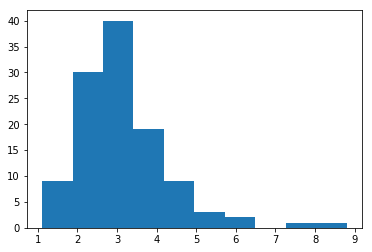

In [9]:
plt.hist(df_G.koi_duration.values[m]);

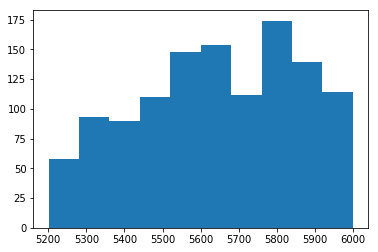

In [10]:
plt.hist(df_G.koi_steff);

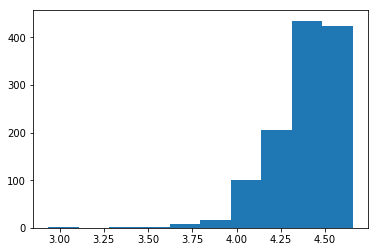

In [11]:
plt.hist(df_G.koi_slogg);

In [12]:
print(len(df.iloc[df.koi_disposition.values=="CONFIRMED"]))

2297


Cadence is around 5 minutes, 23.5 magnitude, S/N = 10. Minimum number of nights needed to observe 1/2 of these.
4 nights in a row is the minimum requirement - but to find subgiants longer baselines are needed. 5% precision.

look at distribution of orbital periods of CVs. Durations are 5 - 10%. 

Simulate a light curve.

In [45]:
import astropy.constants as co
import astropy.units as u

In [107]:
period_days = 1.  # period in days
cadence_minutes = 5  # cadence in minutes
radius = 2 * co.R_jup/co.R_sun  # 1 Jupiter radius in stellar radii
precision = 5  # percent

In [128]:
def make_light_curve(period_days, cadence_minutes, radius, precision, baseline=20):
    period_s = period_days * 24 * 3600
    period_s = period_s*u.s
    G = 6.67e-11
    M = 2e30
    a = (period_s**2*co.G*co.M_sun/(4*np.pi**2))**(1./3)/co.R_sun

    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = period_days # period_days                   #orbital period
    params.rp = radius                       #planet radius (in units of stellar radii)
    params.a = a # (period_s**2*G*M/(4*np.pi**2))/6.955e8  #semi-major axis (in units of stellar radii)
    params.inc = 90.                      #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"        #limb darkening model
    params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients

    cadence = cadence_minutes/(24*60)  # 30 minute cadence in days
    t = np.arange(0, baseline, cadence)  #times at which to calculate light curve [days]
    m = batman.TransitModel(params, t)    #initializes model

    flux = m.light_curve(params)          #calculates light curve

    f = flux + np.random.randn(len(t))*precision*1e-2
    
    return t, f

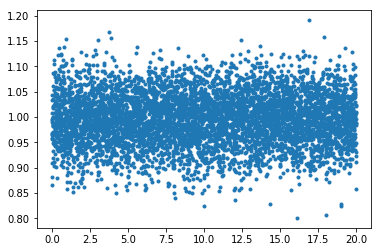

In [129]:
t, f = make_light_curve(period_days, cadence_minutes, radius, precision)
plt.plot(t, f, ".")

In [130]:
from astropy.stats import BoxLeastSquares

model = BoxLeastSquares(t, f, dy=precision*1e-2)
periodogram = model.autopower(0.2)

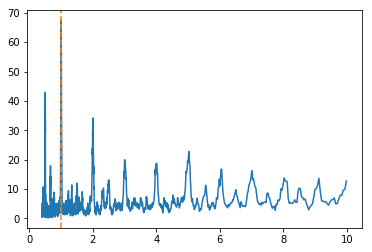

In [131]:
plt.plot(periodogram.period, periodogram.power)
plt.axvline(period_days, color="tab:orange", ls="--")

In [132]:
print(periodogram.period[periodogram.power == max(periodogram.power)][0])

1.0000207957745402


Now try a range of radii and orbital periods.

In [156]:
Ntrials = 2
Norbs = 3
Nrads = 4
porbs = 10**(np.linspace(.5, 1, Norbs))
radii = np.linspace(.5, 2, Nrads)
recovered, true_p = [np.zeros((Norbs, Nrads, Ntrials)) for i in range(2)]

for k in range(Ntrials):
    print(k+1, "of", Ntrials, "trials")
    for i in range(Norbs):
        print(i+1, "of", Norbs, "p_orbs")
        for j in range(Nrads):
            t, f = make_light_curve(porbs[i], cadence_minutes, radii[j], precision)
            model = BoxLeastSquares(t, f, dy=precision*1e-2)
            periodogram = model.autopower(0.2)
            recovered[i, j, k] = periodogram.period[periodogram.power == max(periodogram.power)][0]
            true_p[i, j, k] = porbs[i]

0 of 2 trials
0 of 3 p_orbs
1 of 3 p_orbs
2 of 3 p_orbs
1 of 2 trials
0 of 3 p_orbs
1 of 3 p_orbs
2 of 3 p_orbs


Were the recovered periods within 10% of the injected ones?

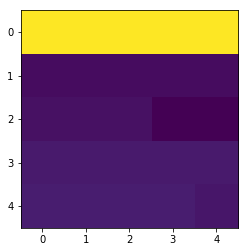

In [154]:
success = true_p/(true_p - recovered)
success_hist = np.zeros((Norbs, Nrads))

for i in range(Norbs):
    for j in range(Nrads):
        success_hist[i, j] = sum(success[i, j, :])
plt.imshow(success)